# Keyword Extraction with Clustering Algorithms

This project aims to perform unsupervised keyword extraction using word embeddings and clustering algorithms. Given a piece of text, the model should output keywords/keyphrases that best capture the gist of the text.

# Related Work

This project was inspired by [Semantic Unsupervised Automatic Keyphrases
Extraction by Integrating Word Embedding with
Clustering Methods](https://www.mdpi.com/2414-4088/4/2/30), written by Isabella Gagliardi and Maria Teresa Artese, published in the Multimodal Technologies and Interaction (MTI) journal in June 2020. The paper introduces a method that performs keyword extraction by combining word embeddings and clsutering algorithms, which is the exact same task that this project seeks to complete. The paper uses Kaggle's [Food.com Recipes and Interactions](https://www.kaggle.com/shuyangli94/food-com-recipes-and-user-interactions) and [FilmTV movies](https://www.kaggle.com/stefanoleone992/filmtv-movies-dataset) datasets that are in both Italian and English. Because these two languages have different syntactic rules, the paper uses different methods to extract keyword candidates from the documents. As for word embeddings, the paper uses Word2vec trained on google news, Word2vec trained on Wikipedia, and GloVe pre-trained vectors. As for clustering algorithms, the paper uses Affinity Propagation, K-Means clustering, and hierarchical clustering. These algorithms are applied to similarity matrics computed based on cosine similarity between word embeddings. For evaluation, the paper uses the Sørensen–Dice similarity coefficient to compare results obtained from the clustering algorithms to TF-IDF, TextRank, and RAKE.

I originally wanted to replicate the paper's results, but because the paper contains rather vague descriptions of implementation details and that there was only a limited amount of time, I decided to make more liberal deviations/explorations. The dataset I used is the [“Arxiv NLP papers with GitHub link” dataset](https://www.kaggle.com/shujian/arxiv-nlp-papers-with-github-link) provided by [Shujian Liu](https://www.kaggle.com/shujian) on Kaggle. It contains the abstracts, Arxiv links, GitHub links, IDs, and titles of 106 Arxiv papers on Natural Language Processing (NLP). For this specific project, I used the "abstract" column for keywork extraction. I used fastText instead of GloVe or Word2vec because it is capable of handling out-of-vocabulary words by itself. For clustering algorithms, I used Affinity Propagation, K-Means clustering, and Mean Shift. I directly applied these algorithms to the word embeddings. For evaluation, I developed my own evaluation metric that used the SD coefficient while taking string-to-string similarity into account. I used this metric to compare the clustering algorithms against TextRank and RAKE.

I have only provided an overview of the project in the previous paragraph. More details can be found in the appropriate sections below.

# Preprocessing

In [1]:
!pip install pandas
!pip install sklearn
!pip install gensim
!pip install textblob
!pip install nltk
!pip install spacy
!python -m spacy download en_core_web_sm

[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [2]:
import spacy
import pandas as pd
import nltk

In [3]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('brown')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\monku\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\monku\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\monku\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\monku\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [4]:
papers_df = pd.read_csv("papers.csv")
docs = papers_df["Abstract"] # list of raw paper abstracts (docs)

In [5]:
from textblob import TextBlob
from nltk.corpus import stopwords
sw = stopwords.words('english')

nlp = spacy.load("en_core_web_sm")

def select_candidates(text):
    """
    Select keyword candidates for a given doc.
    Candidates contain nouns and noun phrases that are not stop words.
    """
    doc = nlp(text.lower())
    blob = TextBlob(text.lower())
    np = blob.noun_phrases
    n = []
    for token in doc:
        if token.pos_ == "NOUN":
            n.append(token.text)
    candidates = [word for word in list(set(n + np)) if word not in sw]
    return candidates

In [6]:
doc_toks = docs.map(select_candidates) # list of doc keyword candidate lists
doc_toks

0      [baselines, tasks, structures, sentiment, mult...
1      [performance, tasks, speaker identification, s...
2      [tasks, research, propagation patterns, spread...
3      [performance, lengthy dialogue histories, inve...
4      [performance, tasks, semantic properties, unse...
                             ...                        
101    [bilstm, vietnamese word segmentation, obtains...
102    [self, information, distributions, units, stan...
103    [likelihood, language, graph, hierarchical rep...
104    [performance, number, question, weber 's law, ...
105    [capacity, work, training, pre, state, benefit...
Name: Abstract, Length: 106, dtype: object

# Import and compute word embeddings

The function below is adapted from the one provided by Stanford [here](https://web.stanford.edu/class/cs224n/materials/Gensim%20word%20vector%20visualization.html).

In [7]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def display_pca_scatterplot(doc_toks, doc_embs, i):
    """
    Visualize word embeddings.
    """
    words = doc_toks[i]
    word_vectors = doc_embs[i]

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(10,10))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.01, y+0.01, word)

Initially I used GloVe embeddings, but after uncovering GloVe's limitations with regard to this project, I turned to use fastText embeddings. More details can be found below.

## GloVe embeddings

[GloVe](https://www.aclweb.org/anthology/D14-1162/), its name taken from "Global Vectors", is an unsupervised learning algorithm applied to obtain vector representations for words. The collection of vectors I used was trained on Wikipedia 2014 and Gigaword 5. However, GloVe has two major limitations in the context of this project:
1. As demonstrated in a cell below, GloVe has many out-of-vocabulary (OOV) words. Many of these words may carry significant meaning in the context of its corresponding document, but they will be left out during clustering because they do not have proper embeddings. To tackle this issue, the best approach would be to train another model on another set of training data so that it can predict embeddings for OOV words.
2. Affinity Propagation would fail to converge on the embeddings of several documents regardless of which set of hyperparameters is used. I removed the corresponding cell from the notebook to keep things clearer, but the image below shows the warning message. ![image](converge.png)

In [8]:
import gensim
import gensim.downloader as api

info = api.info()
glove = api.load("glove-wiki-gigaword-300")

In [9]:
import numpy as np

def doc_to_emb(doc):
    """
    Create GloVe word embeddings for the candidates of a doc.
    For a compound word, use the element-wise average of the embeddings of the single words contained.
    """
    embs = []
    remove = []
    for word in doc:
        emb = np.array(np.zeros(300))
        subs = word.split()
        count = len(subs)
        for w in subs:
            try:
                emb = np.add(emb, np.array(glove[w]))
            except KeyError:
                count -= 1
        if count > 0:
            emb = np.divide(emb, count)
            embs.append(emb)
        else:
            remove.append(word)
    for word in remove: doc.remove(word)
    return doc, embs

In [10]:
# Create GloVe word embeddings for candidates of each doc.
doc_embs_glove = [] # list of doc keyword candidate GloVe embedding lists
for doc_tok in doc_toks:
    doc_tok, embs = doc_to_emb(doc_tok)
    doc_embs_glove.append(embs)

In [11]:
# Inspect out-of-vocab words.
for doc_tok in doc_toks:
    for tok in doc_tok:
        for t in tok.split():
            try: emb = glove[t]
            except KeyError: print(t)

encoder-discriminator
sincnet
utilizable
human-human
tweet-level
task-specific
esim
softmax
esim
multi-domain
35\
97.38\
88.51\
global-local
self-attention
out-of-domain
plutchik
e-c
multi-emotion
semeval
script-like
zipfian
frequency-rank
zipfian
speaker/listener
sentence-level
phrase-level
bi-lstm
medsim
medicine-specific
tvsum
self-attention
9.4b
abstractive
abstractive
summarizer
seq2seq
seq2seq
abstractive
evomsa
evomsa
multi-view
multi-task
kbqa
multi-view
multi-task
hybrid-hmm
ustc-nel
iwslt
2018.
lstm
softmax
fasttext
free-text
single-turn
coqa
coreference
chat-crowd
chat-crowd
bias-variance
bias-variance
bias-variance
founderofcompany
cifar-10
svhn
in-distribution
2.5x
softmax
softmax
sequence-to-sequence
wmt17
sentence-wise
non-smooth
feature-level
omg-empathy
lstm
held-out
with-those
2019.
of-and
english-bengali
discriminability
oxford-102
multi-speaker
out-of-domain
multi-speaker
time-intensive
dfgn
dfgn
cloze
non-autoregressive
root-to-leaf
cnns
multi-task
multi-task
multi

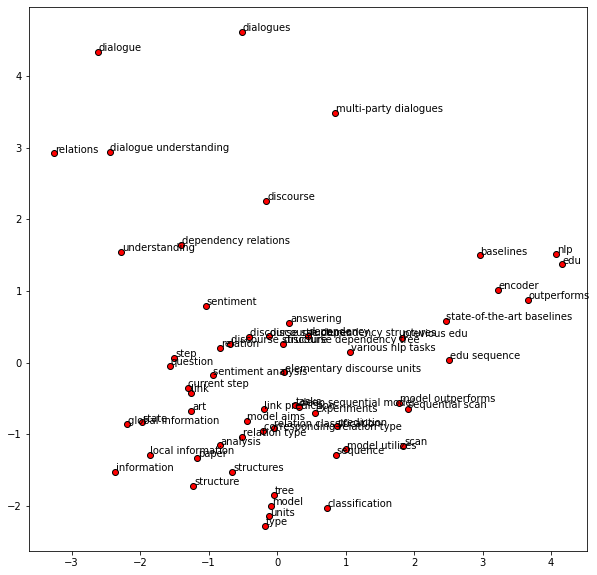

In [12]:
# Visualize the GloVe embeddings of candidates of the first doc.
display_pca_scatterplot(doc_toks, doc_embs_glove, 0)

It needs to be noted that the visualization is only 2D while the word embeddings have 300 dimensions, so distance between points is not representative of the dissimilarity between the corresponding words. Nevertheless, according to GloVe, "dialogue" and "dialogues" only have a similarity score of around 0.72.

In [13]:
glove.similarity("dialogue", "dialogues")

0.71682554

## FastText embeddings

To tackle the issue of OOV words, I decided to use [fastText](https://fasttext.cc/) instead of training another model for GloVe, because the latter would largely depend on good training data. It would take a significant amount of time to find such data and train the model while this part of the project should not be the main focus. According to the [original paper](https://arxiv.org/abs/1607.04606), fastText uses an underlying skipgram model, where each word is represented as a bag of character n-grams. A vector is associated with each character n-gram, and words are represented as the sum of these vectors. Therefore, it is capable of generating embeddings for OOV words based on their character n-grams. It can also handle compound words.

To use fastText without training a corpus from scratch, I obtained pre-trained Wikipedia word vectors in the following way:
1. Download *English: bin + text* from [here](https://fasttext.cc/docs/en/pretrained-vectors.html). Save it in the same directory as this notebook.
2. Unzip. Two files would appear: "wiki.en.vec" and "wiki.en.bin". The latter would be used in the following cell.

The following cell will take a long time to run. You may run into a memory error if other kernels are active.

In [14]:
from gensim.models import FastText as ft
model = ft.load_fasttext_format("wiki.en.bin")

<ipython-input-14-b5dba8d33f6b>:2: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  model = ft.load_fasttext_format("wiki.en.bin")


As demonstrated in the cell below, even though "self-attention" is not in the pre-trained vocabulary, fastText is still able to create a vector representation for it. This shows that fastText has better coverage than GloVe.

In [15]:
print("self-attention" in model.wv.vocab)
print("self-attention" in model.wv)
print(model["self-attention"])

False
True


<ipython-input-15-27b23aba071c>:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  print(model["self-attention"])


[-0.23957437 -0.32297555 -0.24627851  0.19866364 -0.22185782 -0.3030922
 -0.04469643 -0.15017727 -0.26923093  0.26155347 -0.28236964 -0.02646313
 -0.17845148  0.03845784  0.1683383  -0.24089947 -0.17072809 -0.01827928
  0.1753108   0.17592882  0.09995519  0.17614907 -0.15392523 -0.20798439
 -0.35987282  0.07766123  0.12314619 -0.01889289  0.34533432  0.34039497
 -0.14624324  0.38168535 -0.29436883  0.29641742  0.12930991 -0.41639465
 -0.05832529  0.0052346   0.16216975  0.02111896 -0.01838155 -0.0136331
 -0.1358394  -0.2231264   0.26378632  0.02882122  0.08756168  0.04818382
  0.00368288 -0.007054   -0.08663464 -0.55781096 -0.04023812 -0.28837302
 -0.08175195 -0.19646545 -0.01859382 -0.21199477 -0.1484177   0.08732152
 -0.00153419 -0.12473331  0.06768028  0.05421545 -0.06274024 -0.23881496
 -0.05764224  0.27522486 -0.00421411 -0.00463037  0.03967226  0.02616695
  0.3118208  -0.09176192 -0.15023772  0.3997346   0.08368417  0.19878031
 -0.03116708  0.05409343 -0.03040276  0.04381429 -0.0

In [16]:
# Create fastText word embeddings for candidates of each doc.
doc_embs = [] # # list of doc keyword candidate fastText embedding lists
for doc_tok in doc_toks:
    doc_emb = []
    for tok in doc_tok:
        doc_emb.append(model[tok])
    doc_embs.append(doc_emb)

<ipython-input-16-780c1fa6c0f5>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  doc_emb.append(model[tok])


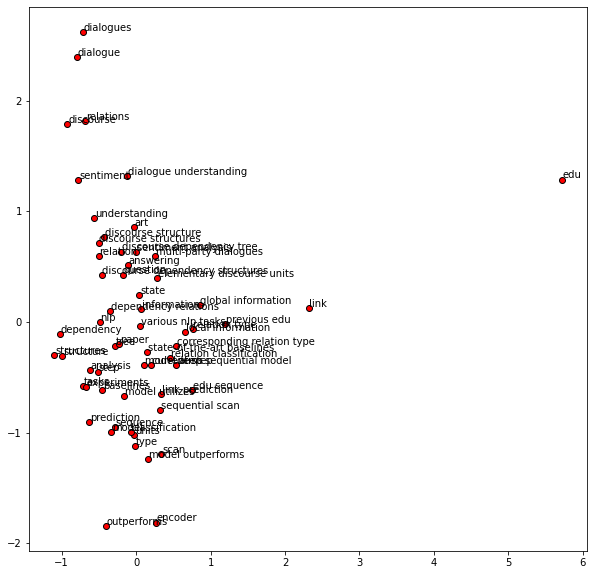

In [17]:
# Visualize the fastText embeddings of candidates of the first doc.
display_pca_scatterplot(doc_toks, doc_embs, 0)

Compared to the 0.72 returned by GloVe, fastText gives a similarity score of around 0.86 to "dialogue" and "dialogues". This higher score makes more sense because "dialogues" is only the plural form of "dialogue". Thus, fastText appears to be a more reliable word vector model.

In [18]:
model.similarity("dialogue", "dialogues")

<ipython-input-18-ef78777a327a>:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  model.similarity("dialogue", "dialogues")


0.8556871

# Apply Clustering Algorithms

In this section of the notebook, I applied Affinity Propagation, K-Means, and Mean Shift on the word embeddings of each document. K-Means require the number of clusters (n_clusters) as its input, while Affinity Propagation and Mean Shift do not. Thus, to ensure fairness during evaluation, I applied K-Means twice, once setting n_clusters based on results returned by Affinity Propagation, the other time setting n_clusters based on results returned by Mean Shift.

I tried DBSCAN and experimented with different hyperparameters, but it would either treat almost all word embeddings as noise, or it would put almost all of them into the same cluster. This is probably because density among the word embeddings does not vary too much, thus DBSCAN would not be an appropriate algorithm to apply in this scenario. I also tried hierarchical clustering, but was unable to find an effective way of extracting the centroids.

The function below is adapted from the similarity function defined in the Gensim source code [here](https://github.com/RaRe-Technologies/gensim/blob/develop/gensim/models/keyedvectors.py).

In [19]:
def simi(x, y):
    """
    Calculate the consine similarity between two word embeddings.
    """
    return np.dot(matutils.unitvec(x), matutils.unitvec(y))

## Affinity Propagation

In [20]:
from sklearn.cluster import AffinityPropagation

ap_kw = [] # list of keyword lists returned by Affinity Propagation

for i, doc_emb in enumerate(doc_embs):
    ap = AffinityPropagation(random_state=5).fit(doc_emb)
    centers = ap.cluster_centers_
    indices = []
    doc_kw = []
    
    # Identify the centers of these clusters.
    for c in centers:
        for j, emb in enumerate(doc_emb):
            if np.array_equal(emb, c):
                indices.append(j)
    doc_kw = [doc_toks[i][k] for k in indices]
    ap_kw.append(doc_kw)

## K-means (n_clusters based on results from Affinity Propagation)

In [21]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from gensim import matutils

kmeans_kw_ap = [] # list of keyword lists returned by K-Means (n_clusters based on AP)

for i, doc_emb in enumerate(doc_embs):
    n = len(ap_kw[i])
    if n > 0:
        kmeans = KMeans(n_clusters=n, random_state=0).fit(doc_emb)
        centers = kmeans.cluster_centers_
        doc_kw = []
        
        # Identify the centers of the clusters by finding the their closest word embeddings.
        for c in centers:
            max_sim = -1
            center = 0
            for j, emb in enumerate(doc_emb):
                sim = simi(emb, c)
                if sim > max_sim:
                    max_sim = sim
                    center = j
            doc_kw.append(doc_toks[i][center])
        kmeans_kw_ap.append(doc_kw)
    else:
        kmeans_kw_ap.append([])

## Mean Shift

In [22]:
from sklearn.cluster import MeanShift

ms_kw = [] # list of keyword lists returned by Mean Shift

for i, doc_emb in enumerate(doc_embs):
    ms = MeanShift(bandwidth=3.78).fit(doc_emb)
    centers = ms.cluster_centers_
    
    # Map elements to their corresponding cluster.
    clusters = {}
    for c in range(len(ms.cluster_centers_)): clusters[c] = []
    for j, emb in enumerate(doc_emb):
        cluster_id = ms.labels_[j]
        clusters[cluster_id].append(j)
    
    # Identify the centers of the clusters by finding the their closest word embeddings.
    doc_kw = []
    for k, c in enumerate(centers):
        cluster = clusters[k]
        max_sim = -1
        center = 0
        for idx in cluster:
            sim = simi(doc_emb[idx], c)
            if sim > max_sim:
                max_sim = sim
                center = idx
        doc_kw.append(doc_toks[i][center])
    
    ms_kw.append(doc_kw)

I tuned the bandwidth parameter of the Mean Shift algorithm by ensuring that the average n_clusters generated by Mean Shift was close to the average n_clusters generated by Affinity Propagation (shown in the following cell). This was to ensure fairness during evaluation. After several experiments, I discovered that a bandwidth of 3.78 would result in similar average n_clusters for the two algorithms:

In [23]:
ap_n_all = [len(ap) for ap in ap_kw]
ap_n = sum(ap_n_all)/len(ap_kw)
print("The average n_clusters for Affinity Propagation is: " + str(ap_n))

ms_n_all = [len(ms) for ms in ms_kw]
ms_n = sum(ms_n_all)/len(ms_kw)
print("The average n_clusters for Mean Shift is: " + str(ms_n))

The average n_clusters for Affinity Propagation is: 8.245283018867925
The average n_clusters for Mean Shift is: 8.132075471698114


## K-means (n_clusters based on results from Mean Shift)

In [24]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from gensim import matutils

kmeans_kw_ms = [] # list of keyword lists returned by K-Means (n_clusters based on MS)

for i, doc_emb in enumerate(doc_embs):
    n = len(ms_kw[i])
    if n > 0:
        kmeans = KMeans(n_clusters=n, random_state=0).fit(doc_emb)
        centers = kmeans.cluster_centers_
        doc_kw = []
        
        # Identify the centers of the clusters by finding the their closest word embeddings.
        for c in centers:
            max_sim = -1
            center = 0
            for j, emb in enumerate(doc_emb):
                sim = simi(emb, c)
                if sim > max_sim:
                    max_sim = sim
                    center = j
            doc_kw.append(doc_toks[i][center])
        kmeans_kw_ms.append(doc_kw)

# Evaluate clustering algorithms with other methods

In this section, I will compare the aforementioned clustering algorithms to [RAKE (Rapid Automatic Keyword Extraction)](https://www.researchgate.net/publication/227988510_Automatic_Keyword_Extraction_from_Individual_Documents) and [TextRank](https://www.aclweb.org/anthology/W04-3252/), both of which are widely used keyword extraction algorithms. Given a piece of text, they would return a list of all identified candidate words/phrases ranked in the order of their significance within the text. Originally I also planned to use the [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) (term frequency–inverse document frequency) algorithm, but it woule require a larger corpus of documents to be fully effective.

As discussed in the previous section, Affinity Propagation and Mean Shift would generate their own n_clusters, which would lead to keyword lists of different lengths. Thus, I sliced the lists returned by RAKE and TextRank differently for each respective algorithm.

## RAKE

In [25]:
!pip install rake-nltk

In [26]:
from rake_nltk import Rake

r = Rake()
rake_ap = [] # RAKE based on number of keywords returned by Affinity Propagation
rake_ms = [] # RAKE based on number of keywords returned by Mean Shift
for i, doc in enumerate(docs):
    r.extract_keywords_from_text(doc)
    n_ap = len(ap_kw[i])
    n_ms = len(ms_kw[i])
    rake_ms.append(r.get_ranked_phrases()[0:n_ms])
    rake_ap.append(r.get_ranked_phrases()[0:n_ap])

## TextRank

In [27]:
!pip install pytextrank

In [28]:
import pytextrank

tr = pytextrank.TextRank()
nlp.add_pipe(tr.PipelineComponent, name="textrank", last=True)

In [29]:
tr_ap = [] # TextRank based on number of keywords returned by Affinity Propagation
tr_ms = [] # TextRank based on number of keywords returned by Mean Shift
for i, doc in enumerate(docs):
    doc = nlp(doc)
    n_ap = len(ap_kw[i])
    n_ms = len(ms_kw[i])
    tr_ms.append(doc._.phrases[0:n_ms])
    tr_ap.append(doc._.phrases[0:n_ap])

## Evaluation

The [Sørensen–Dice (SD) similarity coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient), used in the [Semantic Unsupervised Automatic Keyphrases
Extraction by Integrating Word Embedding with
Clustering Methods](https://www.mdpi.com/2414-4088/4/2/30) paper, is capable of measuring string-to-string similarity:

In [30]:
import textdistance

textdistance.sorensen_dice.similarity('apple', 'apples')

0.9090909090909091

But it would fail to take string-to-string similarity into account when two lists of strings are passed in:

In [31]:
textdistance.sorensen_dice.similarity(['apple', 'pear'], ['apples', 'pears'])

0.0

In [32]:
textdistance.sorensen_dice.similarity(['apple', 'pear'], ['apple', 'pear'])

1

I found no existing metric that compares the similarity of two lists of strings (of the same size) that would take string-to-string similarity into consideration. Thus I developed a custom metric that computes the SD similarity for each word in the first list with respect to every word in the second list, then returns the average of these values.

In [33]:
def evaluate(l1, l2):
    """
    Evaluates the similarity of two lists of strings.
    """
    sd_sim = []
    for a in l1:
        element_sim = []
        for b in l2:
            element_sim.append(textdistance.sorensen_dice.similarity(str(a), str(b)))
        element_sim = sum(element_sim)/len(l2)
        sd_sim.append(element_sim)
    return sum(sd_sim)/len(l1)

In the cell below, I compare two keyword extraction methods against each other by taking the average of the evaluation scores calculated between the lists of keywords for each document.

In [34]:
def compare(m1, m2):
    """
    Compares two keyword extraction methods.
    """
    scores = []
    for a, b in zip(m1, m2):
        if len(a) > 0:
            scores.append(evaluate(a, b))
    return sum(scores)/len(scores)

Compare methods based on the number of keywords returned by Affinity Propagation:

In [35]:
ap_rake = compare(ap_kw, rake_ap) # AP vs. rake
ap_tr = compare(ap_kw, tr_ap) # AP vs. textrank
km_rake_ap = compare(kmeans_kw_ap, rake_ap) # k-means (AP) vs. rake (AP)
km_tr_ap = compare(kmeans_kw_ap, tr_ap) # k-means (AP) vs. textrank (AP)
rake_tr_ap = compare(rake_ap, tr_ap) # rake (AP) vs. textrank (AP)

In [36]:
print("AP vs. RAKE: " + str(round(ap_rake, 2)))
print("AP vs. TextRank: " + str(round(ap_tr, 2)))
print("K-Means vs. RAKE: " + str(round(km_rake_ap, 2)))
print("K-Means vs. TextRank: " + str(round(km_tr_ap, 2)))
print("RAKE vs. TextRank: " + str(round(rake_tr_ap, 2)))

AP vs. RAKE: 0.4
AP vs. TextRank: 0.4
K-Means vs. RAKE: 0.38
K-Means vs. TextRank: 0.4
RAKE vs. TextRank: 0.52


Compare methods based on the number of keywords returned by Mean Shift:

In [37]:
ms_rake = compare(ms_kw, rake_ms) # mean shift vs. rake
ms_tr = compare(ms_kw, tr_ms) # mean shift vs. textrank
km_rake_ms = compare(kmeans_kw_ms, rake_ms) # k-means (MS) vs. rake (MS)
km_tr_ms = compare(kmeans_kw_ms, tr_ms) # k-means (MS) vs. textrank (MS)
rake_tr_ms = compare(rake_ms, tr_ms) # rake (MS) vs. textrank (MS)

In [38]:
print("MS vs. RAKE: " + str(round(ms_rake, 2)))
print("MS vs. TextRank: " + str(round(ms_tr, 2)))
print("K-Means vs. RAKE: " + str(round(km_rake_ms, 2)))
print("K-Means vs. TextRank: " + str(round(km_tr_ms, 2)))
print("RAKE vs. TextRank: " + str(round(rake_tr_ms, 2)))

MS vs. RAKE: 0.3
MS vs. TextRank: 0.33
K-Means vs. RAKE: 0.38
K-Means vs. TextRank: 0.41
RAKE vs. TextRank: 0.52


Plot results:

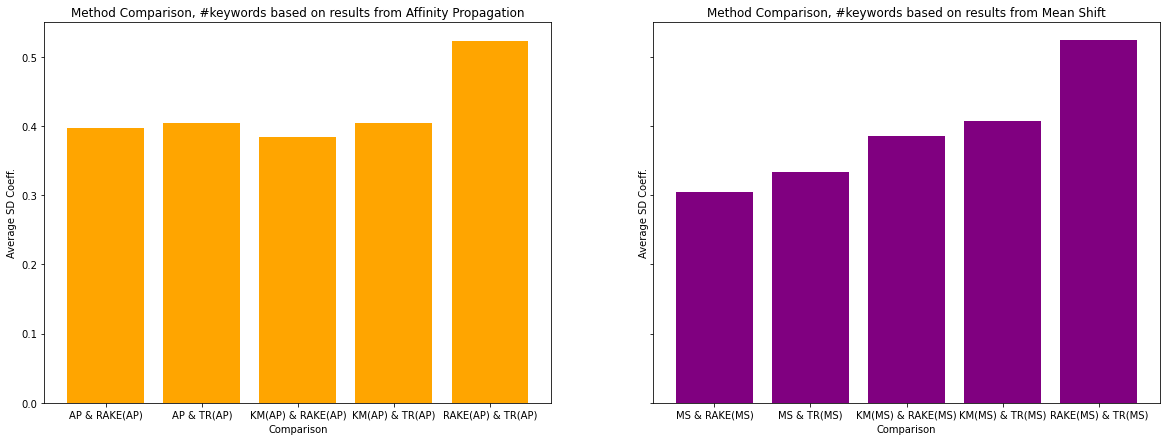

In [39]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,7), sharey=True)

x_ap = ['AP & RAKE(AP)', 'AP & TR(AP)', 'KM(AP) & RAKE(AP)', 'KM(AP) & TR(AP)', 'RAKE(AP) & TR(AP)']
x_ap_pos = [i for i, _ in enumerate(x_ap)]
y_ap = [ap_rake, ap_tr, km_rake_ap, km_tr_ap, rake_tr_ap]

ax1.bar(x_ap, y_ap, color='orange')
ax1.set_xlabel("Comparison")
ax1.set_ylabel("Average SD Coeff.")
ax1.set_title("Method Comparison, #keywords based on results from Affinity Propagation")

x_ms = ['MS & RAKE(MS)', 'MS & TR(MS)', 'KM(MS) & RAKE(MS)', 'KM(MS) & TR(MS)', 'RAKE(MS) & TR(MS)']
x_ms_pos = [i for i, _ in enumerate(x_ms)]
y_ms = [ms_rake, ms_tr, km_rake_ms, km_tr_ms, rake_tr_ms]

ax2.bar(x_ms, y_ms, color='purple')
ax2.set_xlabel("Comparison")
ax2.set_ylabel("Average SD Coeff.")
ax2.set_title("Method Comparison, #keywords based on results from Mean Shift")

plt.show()

In both scenarios, RAKE and TextRank have the highest SD similarity score (0.52 in both graphs) mostly because both are robust keyword extraction algorithms with high performance on average. K-Means (AP) scored 0.38 with RAKE (AP) and 0.4 with TextRank (AP), and K-Means (MS) scored 0.38 with RAKE (MS) and 0.41 with TextRank (MS), resulting in an average score of 0.39. Affinity Propagation scored 0.4 with both RAKE and TextRank, resulting in an average score of 0.4. Mean Shift scored 0.3 with RAKE and 0.33 with TextRank, resulting in an average score of 0.32.

These numerical results imply that all three clustering algorithms have questionable performance compared to RAKE and TextRank on keyword extraction based on the 106 NLP paper abstracts. Mean Shift performed much worse than K-Means and Affinity Propagation. Upon further investigation, I discovered that this is probably because the embedding dimension of 300 is too high for Mean Shift to work effectively. According to [A review of mean-shift algorithms for clustering](https://arxiv.org/abs/1503.00687) by Miguel Á. Carreira-Perpiñán (included in [*Handbook of Cluster Analysis*](https://www.taylorfrancis.com/books/e/9780429185472), edited by Christian
Hennig, Marina Meila, Fionn Murtagh, and Roberto Rocci), the kernel density estimator applied by the Mean Shift algorithm would break down in higher dimensions (page 7 of the paper).

# Future work

More work could be done in the following directions:
- **Data**: Scale up by using a larger corpus of documents, possibly of a genre different from scholarly writing. This may cause the clustering algorithms to behave differently from what was seen above.
- **Handling OOV words**: Train a model for GloVe that predicts embeddings for OOV words and compares the results to fastText embeddings. This would require experimenting with different sets of training data and hyperparameters to find the optimal combination.
- **Clustering algorithms**: Further investigate if there is a way to extract centroids from results returned by hierarchical clustering. Apply clustering algorithms to similarity matrices and compare to when they are directly applied to word embeddings (in [scikit-learn clustering](https://scikit-learn.org/stable/modules/clustering.html), only AffinityPropagation, SpectralClustering, and DBSCAN accept similarity matrices as input).
- **Evaluation metric**: Develop a more robust metric for evaluating the similarity between two lists of strings and another for comparing two keyword extraction methods. Evaluate against more existing keyword extraction methods.